In [141]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
import seaborn as sns
import os

In [142]:
data_dir = "./data/rawdata/mit/"

In [143]:
class ERDCalculator:
    """
    A class to calculate Event-Related Desynchronization (ERD) from EEG data.
    """
    def __init__(self, sampling_freq, epoch_pre_stimulus_seconds, epoch_post_stimulus_seconds, bandpass_low, bandpass_high, channel_names, focus_channels_indices):
        """
        Initializes the ERDCalculator with necessary parameters.

        Args:
            sampling_freq (float): The sampling frequency of the EEG data.
            epoch_pre_stimulus_seconds (float): Duration of the epoch before the stimulus in seconds.
            epoch_post_stimulus_seconds (float): Duration of the epoch after the stimulus in seconds.
            bandpass_low (float): The low cut-off frequency for the bandpass filter.
            bandpass_high (float): The high cut-off frequency for the bandpass filter.
            channel_names (list): A list of all channel names in the EEG data.
            focus_channels_indices (list): A list of indices for the channels of interest.
        """
        self.sampling_freq = sampling_freq
        # Samples before the marker
        self.samples_before_marker = int(epoch_pre_stimulus_seconds * sampling_freq)
        # Samples after the marker
        self.samples_after_marker = int(epoch_post_stimulus_seconds * sampling_freq)
        # Total samples in an epoch
        self.epoch_total_samples = self.samples_before_marker + self.samples_after_marker
        self.b, self.a = butter(5, [bandpass_low, bandpass_high], btype='band', fs=sampling_freq)
        self.channel_names = channel_names
        self.channel_count = len(channel_names)
        self.focus_channels_indices = focus_channels_indices

    def calculate_erd(self, epoch_data):
        """
        Calculates the ERD for a given epoch.

        Args:
            epoch_data (np.array): The EEG data for a single epoch.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None
        
        # Apply the bandpass filter
        filtered_epoch = filtfilt(self.b, self.a, epoch_data, axis=1)
        
        # print(filtered_epoch)

        # Separate pre and post-stimulus data
        pre_stimulus_data = filtered_epoch[:, :self.samples_before_marker]
        post_stimulus_data = filtered_epoch[:, self.samples_before_marker:]
        
        # pre_stimulus_data = filtered_epoch[:, self.samples_before_marker-int(0.2*self.sampling_freq):self.samples_before_marker]
        # post_stimulus_data = filtered_epoch[:, self.samples_before_marker:self.samples_before_marker + int(0.6*self.sampling_freq)]

        # Calculate power for pre and post stimulus periods
        pre_power = np.nanmean(pre_stimulus_data ** 2, axis=1)
        post_power = np.nanmean(post_stimulus_data ** 2, axis=1)

        # Calculate ERD, avoiding division by zero
        non_zero_pre_power_indices = pre_power != 0
        erd_percent = np.full(self.channel_count, np.nan)
        erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
        
        # Extract ERD for focus channels
        erd_percent_focus = erd_percent[self.focus_channels_indices]
        
        # Return the mean of the absolute ERD values for the focus channels
        if np.any(~np.isnan(erd_percent_focus)):
            return np.nanmean((erd_percent_focus))
        else:
            return None

def analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli=None):
    """
    Analyzes EEG data to calculate and visualize ERD values for different stimuli.

    Args:
        raw_data: The raw EEG data object from a file (e.g., MNE-Python Raw object).
        focus_channel_names (list): A list of channel names to focus on for ERD calculation.
    """
    # --- 1. Data Preparation ---
    df = raw_data.to_data_frame()
    sampling_frequency = raw_data.info['sfreq']
    channel_names = raw_data.ch_names
    annotations = raw_data.annotations

    # --- 2. Process Annotations ---
    annotations_df = pd.DataFrame({
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description.astype(str),
    })
    annotations_df['absolute_onset'] = (annotations_df['onset'] * sampling_frequency).astype(int)
    annotations_df[['desc_main', 'desc_sub']] = (
    annotations_df['description']
      .str
      .split(pat='/', n=1, expand=True)
)

    annotations_df.drop(columns=['description', 'desc_main'], inplace=True)
    annotations_df.rename(columns={'desc_sub': 'description'}, inplace=True)

    # --- 3. Setup ERD Calculator ---
    epoch_pre_stimulus_seconds = 1.0
    epoch_post_stimulus_seconds = 1.0
    bandpass_low = 8.0
    bandpass_high = 30.0 # Alpha band
    focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

    erd_calculator = ERDCalculator(
        sampling_frequency,
        epoch_pre_stimulus_seconds,
        epoch_post_stimulus_seconds,
        bandpass_low,
        bandpass_high,
        channel_names,
        focus_channels_indices
    )

    # --- 4. ERD Calculation Loop ---
    results = []
    
    
    if annotations_df.empty:
        print("No annotations found for the specified stimuli.")
        return 
    for index, row in annotations_df.iterrows():
        onset_sample = row['absolute_onset']
        stimulus_description = row['description']
        
        # Filter for focus stimuli if specified
        if focus_stimuli and stimulus_description not in focus_stimuli:
            continue

        # Define epoch boundaries
        start_sample = onset_sample - erd_calculator.samples_before_marker
        end_sample = onset_sample + erd_calculator.samples_after_marker

        # Ensure the epoch is within the data bounds
        if start_sample >= 0 and end_sample < len(df):
            # Extract epoch data for all channels
            
            epoch_data = df.iloc[start_sample:end_sample][channel_names].values.T
            
            # Calculate ERD
            erd_value = erd_calculator.calculate_erd(epoch_data)

            if erd_value is not None:
                results.append({'stimulus': stimulus_description, 'erd_value': erd_value, 'subject_id': subject_id})

    # --- 5. Results and Visualization ---
    if results:
        results_df = pd.DataFrame(results)
        # print("ERD Calculation Results:")
        # print(results_df)
        return results_df
    else:
        print("No valid ERD results were calculated.")
        
def process_all_subjects(data_dir, focus_channel_names, focus_stimuli=None):
    """
    Processes all subjects in the specified data directory to calculate and visualize ERD values.

    Args:
        data_dir (str): Directory containing the EEG data files.
        focus_channel_names (list): List of channel names to focus on for ERD calculation.
        focus_stimuli (list, optional): List of stimuli descriptions to focus on. If None, all stimuli are processed.
    """
    results = []
    
    vhdr_files = [f for f in os.listdir(data_dir) if f.endswith('.vhdr')]
    
    for vhdr_file in vhdr_files:
        subject_id = vhdr_file.split('.')[0]  # Extract subject ID from filename
        vhdr_path = os.path.join(data_dir, vhdr_file)
        
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        subject_results = analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli)
        
        if subject_results is not None:
            results.append(subject_results)
    if results:
        all_results_df = pd.concat(results, ignore_index=True)
        return all_results_df
    else:
        print("No results found for any subjects.")
        return None

In [144]:
results_df = process_all_subjects(data_dir, focus_channel_names=["C3", "C1", "CP3", "CP1"], focus_stimuli=['S  9', 'S 10', 'S 11'])

Extracting parameters from ./data/rawdata/mit/MIT1.vhdr...
Setting channel info structure...
Reading 0 ... 1098399  =      0.000 ...  1098.399 secs...
Extracting parameters from ./data/rawdata/mit/MIT10.vhdr...
Setting channel info structure...
Reading 0 ... 1269719  =      0.000 ...  1269.719 secs...
Extracting parameters from ./data/rawdata/mit/MIT11.vhdr...
Setting channel info structure...
Reading 0 ... 1174599  =      0.000 ...  1174.599 secs...
Extracting parameters from ./data/rawdata/mit/MIT12.vhdr...
Setting channel info structure...
Reading 0 ... 1445479  =      0.000 ...  1445.479 secs...
Extracting parameters from ./data/rawdata/mit/MIT13.vhdr...
Setting channel info structure...
Reading 0 ... 1119699  =      0.000 ...  1119.699 secs...
Extracting parameters from ./data/rawdata/mit/MIT14.vhdr...
Setting channel info structure...
Reading 0 ... 1213539  =      0.000 ...  1213.539 secs...
Extracting parameters from ./data/rawdata/mit/MIT15.vhdr...
Setting channel info structur

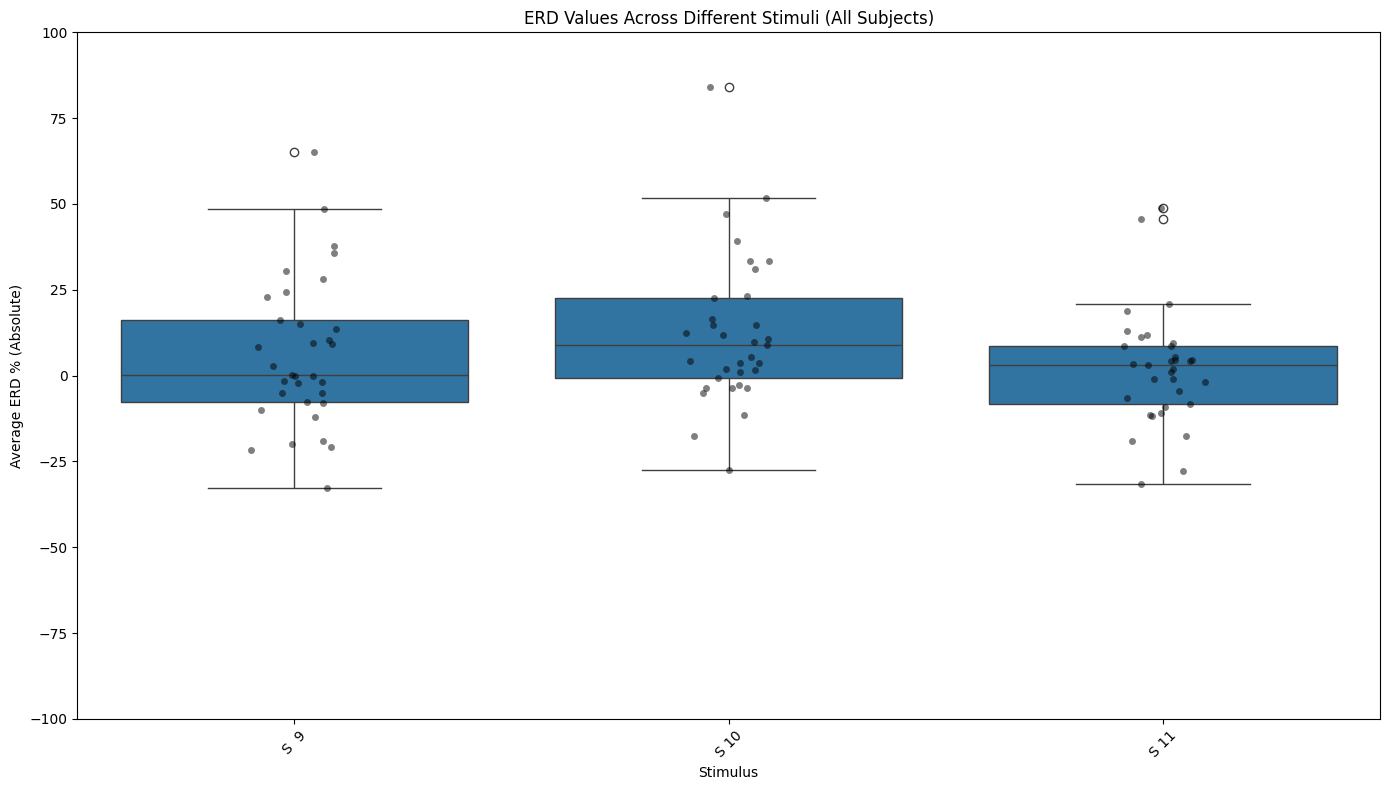

In [145]:
avg_per_subject_stimulus = results_df.groupby(['subject_id', 'stimulus'])['erd_value'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.boxplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus)
sns.stripplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus, jitter=True, color='black', alpha=0.5, dodge=True)
plt.ylim(-100, 100)
plt.title('ERD Values Across Different Stimuli (All Subjects)')
plt.xlabel('Stimulus')
plt.ylabel('Average ERD % (Absolute)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [146]:
class ERDCalculatorWelch:
    """
    A class to calculate Event-Related Desynchronization (ERD) from EEG data.
    """
    def __init__(self, sampling_freq, epoch_pre_stimulus_seconds, epoch_post_stimulus_seconds, bandpass_low, bandpass_high, channel_names, focus_channels_indices):
        """
        Initializes the ERDCalculator with necessary parameters.

        Args:
            sampling_freq (float): The sampling frequency of the EEG data.
            epoch_pre_stimulus_seconds (float): Duration of the epoch before the stimulus in seconds.
            epoch_post_stimulus_seconds (float): Duration of the epoch after the stimulus in seconds.
            bandpass_low (float): The low cut-off frequency for the bandpass filter.
            bandpass_high (float): The high cut-off frequency for the bandpass filter.
            channel_names (list): A list of all channel names in the EEG data.
            focus_channels_indices (list): A list of indices for the channels of interest.
        """
        self.sampling_freq = sampling_freq
        # Samples before the marker
        self.samples_before_marker = int(epoch_pre_stimulus_seconds * sampling_freq)
        # Samples after the marker
        self.samples_after_marker = int(epoch_post_stimulus_seconds * sampling_freq)
        # Total samples in an epoch
        self.epoch_total_samples = self.samples_before_marker + self.samples_after_marker
        self.bandpass_low = bandpass_low
        self.bandpass_high = bandpass_high
        # self.b, self.a = butter(5, [bandpass_low, bandpass_high], btype='band', fs=sampling_freq)
        self.channel_names = channel_names
        self.channel_count = len(channel_names)
        self.focus_channels_indices = focus_channels_indices

    def calculate_erd(self, epoch_data):
        """
        Calculates the ERD for a given epoch.

        Args:
            epoch_data (np.array): The EEG data for a single epoch.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None
        
        # Apply the bandpass filter
        # filtered_epoch = filtfilt(self.b, self.a, epoch_data, axis=1)
        
        # print(filtered_epoch)

        # Separate pre and post-stimulus data
        pre_stimulus_data = epoch_data[:, :self.samples_before_marker]
        post_stimulus_data = epoch_data[:, self.samples_before_marker:]
        
        f_pre, Pxx_pre = welch(pre_stimulus_data, fs=self.sampling_freq, nperseg=256, axis=1)
        f_post, Pxx_post = welch(post_stimulus_data, fs=self.sampling_freq, nperseg=256, axis=1)

        # Ensure the frequency bands are within the range of interest
        band_low_index = np.searchsorted(f_pre, self.bandpass_low)
        band_high_index = np.searchsorted(f_pre, self.bandpass_high)
        if band_low_index >= band_high_index:
            print("Invalid frequency band indices for ERD calculation.")
            return None
        # Extract the power in the alpha band (8-30 Hz)
        pre_power = np.nanmean(Pxx_pre[:, band_low_index:band_high_index], axis=1)
        post_power = np.nanmean(Pxx_post[:, band_low_index:band_high_index], axis=1)


        # Calculate ERD, avoiding division by zero
        non_zero_pre_power_indices = pre_power != 0
        erd_percent = np.full(self.channel_count, np.nan)
        erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
        
        # Extract ERD for focus channels
        erd_percent_focus = erd_percent[self.focus_channels_indices]
        
        # Return the mean of the absolute ERD values for the focus channels
        if np.any(~np.isnan(erd_percent_focus)):
            return np.nanmean((erd_percent_focus))
        else:
            return None

In [147]:
def analyze_single_subject_welch(raw_data, focus_channel_names, subject_id, focus_stimuli=None):
    """
    Analyzes EEG data to calculate and visualize ERD values for different stimuli.

    Args:
        raw_data: The raw EEG data object from a file (e.g., MNE-Python Raw object).
        focus_channel_names (list): A list of channel names to focus on for ERD calculation.
    """
    # --- 1. Data Preparation ---
    df = raw_data.to_data_frame()
    sampling_frequency = raw_data.info['sfreq']
    channel_names = raw_data.ch_names
    annotations = raw_data.annotations

    # --- 2. Process Annotations ---
    annotations_df = pd.DataFrame({
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description.astype(str),
    })
    annotations_df['absolute_onset'] = (annotations_df['onset'] * sampling_frequency).astype(int)
    annotations_df[['desc_main', 'desc_sub']] = (
    annotations_df['description']
      .str
      .split(pat='/', n=1, expand=True)
)

    annotations_df.drop(columns=['description', 'desc_main'], inplace=True)
    annotations_df.rename(columns={'desc_sub': 'description'}, inplace=True)

    # --- 3. Setup ERD Calculator ---
    epoch_pre_stimulus_seconds = 1.0
    epoch_post_stimulus_seconds = 1.0
    bandpass_low = 8.0
    bandpass_high = 30.0 # Alpha band
    focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

    erd_calculator = ERDCalculatorWelch(
        sampling_frequency,
        epoch_pre_stimulus_seconds,
        epoch_post_stimulus_seconds,
        bandpass_low,
        bandpass_high,
        channel_names,
        focus_channels_indices
    )

    # --- 4. ERD Calculation Loop ---
    results = []
    
    
    if annotations_df.empty:
        print("No annotations found for the specified stimuli.")
        return 
    for index, row in annotations_df.iterrows():
        onset_sample = row['absolute_onset']
        stimulus_description = row['description']
        
        # Filter for focus stimuli if specified
        if focus_stimuli and stimulus_description not in focus_stimuli:
            continue

        # Define epoch boundaries
        start_sample = onset_sample - erd_calculator.samples_before_marker
        end_sample = onset_sample + erd_calculator.samples_after_marker

        # Ensure the epoch is within the data bounds
        if start_sample >= 0 and end_sample < len(df):
            # Extract epoch data for all channels
            
            epoch_data = df.iloc[start_sample:end_sample][channel_names].values.T
            
            # Calculate ERD
            erd_value = erd_calculator.calculate_erd(epoch_data)

            if erd_value is not None:
                results.append({'stimulus': stimulus_description, 'erd_value': erd_value, 'subject_id': subject_id})

    # --- 5. Results and Visualization ---
    if results:
        results_df = pd.DataFrame(results)
        # print("ERD Calculation Results:")
        # print(results_df)
        return results_df
    else:
        print("No valid ERD results were calculated.")
        
def process_all_subjects_welch(data_dir, focus_channel_names, focus_stimuli=None):
    """
    Processes all subjects in the specified data directory to calculate and visualize ERD values.

    Args:
        data_dir (str): Directory containing the EEG data files.
        focus_channel_names (list): List of channel names to focus on for ERD calculation.
        focus_stimuli (list, optional): List of stimuli descriptions to focus on. If None, all stimuli are processed.
    """
    results = []
    
    vhdr_files = [f for f in os.listdir(data_dir) if f.endswith('.vhdr')]
    
    for vhdr_file in vhdr_files:
        subject_id = vhdr_file.split('.')[0]  # Extract subject ID from filename
        vhdr_path = os.path.join(data_dir, vhdr_file)
        
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        subject_results = analyze_single_subject_welch(raw_data, focus_channel_names, subject_id, focus_stimuli)
        
        if subject_results is not None:
            results.append(subject_results)
    if results:
        all_results_df = pd.concat(results, ignore_index=True)
        return all_results_df
    else:
        print("No results found for any subjects.")
        return None

In [148]:
results_welch_df = process_all_subjects_welch(data_dir, focus_channel_names=["C3", "C1", "CP3", "CP1"], focus_stimuli=['S  9', 'S 10', 'S 11'])


Extracting parameters from ./data/rawdata/mit/MIT1.vhdr...
Setting channel info structure...
Reading 0 ... 1098399  =      0.000 ...  1098.399 secs...
Extracting parameters from ./data/rawdata/mit/MIT10.vhdr...
Setting channel info structure...
Reading 0 ... 1269719  =      0.000 ...  1269.719 secs...
Extracting parameters from ./data/rawdata/mit/MIT11.vhdr...
Setting channel info structure...
Reading 0 ... 1174599  =      0.000 ...  1174.599 secs...
Extracting parameters from ./data/rawdata/mit/MIT12.vhdr...
Setting channel info structure...
Reading 0 ... 1445479  =      0.000 ...  1445.479 secs...
Extracting parameters from ./data/rawdata/mit/MIT13.vhdr...
Setting channel info structure...
Reading 0 ... 1119699  =      0.000 ...  1119.699 secs...
Extracting parameters from ./data/rawdata/mit/MIT14.vhdr...
Setting channel info structure...
Reading 0 ... 1213539  =      0.000 ...  1213.539 secs...
Extracting parameters from ./data/rawdata/mit/MIT15.vhdr...
Setting channel info structur

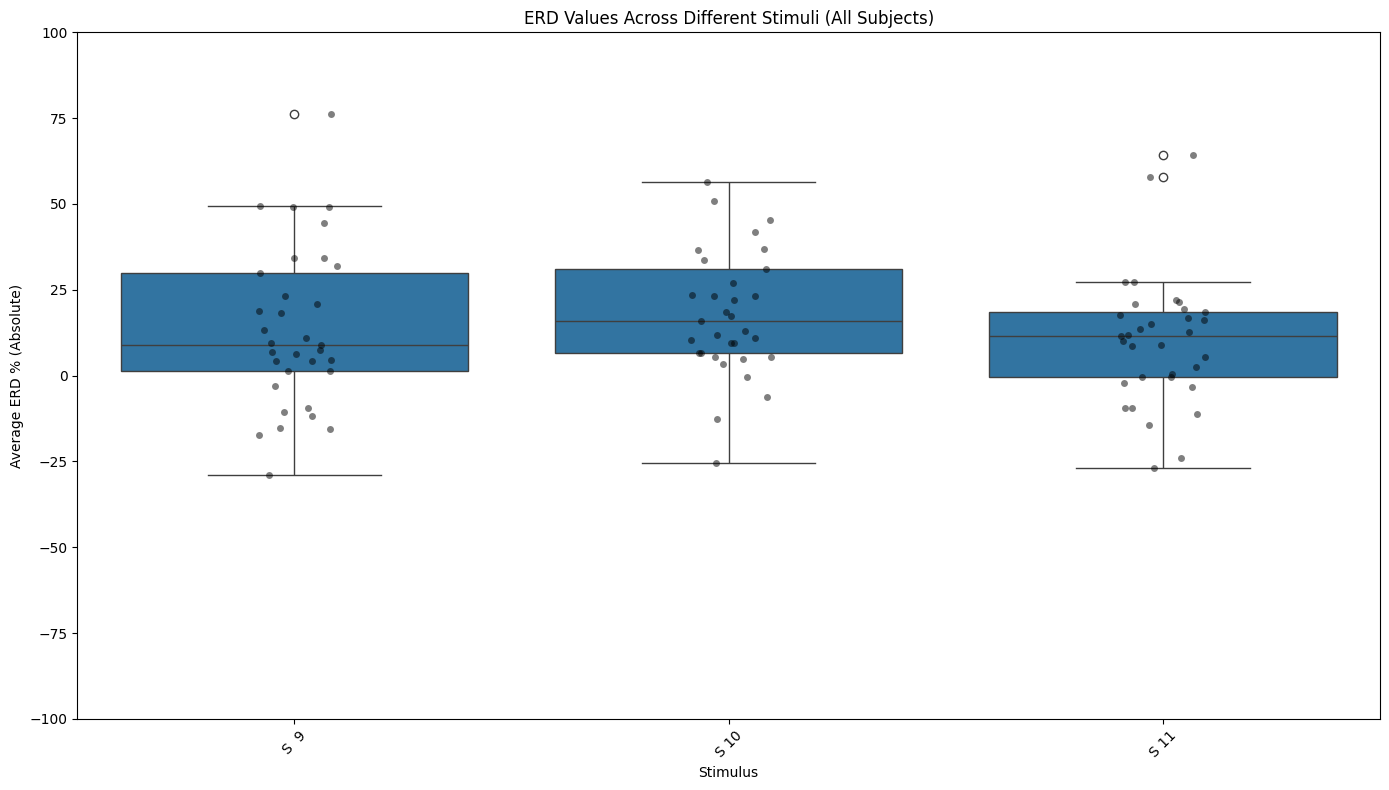

In [149]:
avg_per_subject_stimulus = results_welch_df.groupby(['subject_id', 'stimulus'])['erd_value'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.boxplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus)
sns.stripplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus, jitter=True, color='black', alpha=0.5, dodge=True)
plt.ylim(-100, 100)
plt.title('ERD Values Across Different Stimuli (All Subjects)')
plt.xlabel('Stimulus')
plt.ylabel('Average ERD % (Absolute)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()